# System-Level Memory Optimization - REAL Implementation

This notebook compares two real inference engines:
1. **vLLM** - Optimized production engine with PagedAttention and advanced batching
2. **Transformers** - Standard Hugging Face implementation

Both run actual models and measure real performance differences.

In [2]:
import torch
import time
import gc
import matplotlib.pyplot as plt
import numpy as np
from vllm import LLM, SamplingParams
from transformers import AutoModelForCausalLM, AutoTokenizer

# --- CONFIGURATION ---
# Use a small model to ensure it runs on GPUs with limited VRAM
MODEL_NAME = "gpt2"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
GENERATION_LENGTH = 128

# --- PROMPTS ---
# A batch of prompts with VARYING lengths is crucial to show the difference
PROMPTS = [
    "The weather today is",
    "In a shocking turn of events, scientists have discovered a new species of deep-sea fish that glows in the dark. This discovery",
    "To make the perfect cup of coffee, you must first",
    "The history of the Roman Empire is a complex tapestry woven with threads of conquest, innovation, and betrayal. It began",
    "Hello!",
]

# --- 1. Optimized Engine: vLLM ---
def run_optimized_inference():
    print("--- 🚀 Running Inference with Optimized Engine (vLLM) ---")
    if DEVICE == "cpu":
        print("vLLM requires a GPU. Skipping this test.")
        return 0, 0, 0

    llm = LLM(
        model=MODEL_NAME,
        trust_remote_code=True,
        # A safeguard for GPUs with low VRAM
        gpu_memory_utilization=0.6
    )
    sampling_params = SamplingParams(temperature=0.7, max_tokens=GENERATION_LENGTH)

    start_time = time.perf_counter()
    outputs = llm.generate(PROMPTS, sampling_params)
    end_time = time.perf_counter()

    total_time = end_time - start_time
    total_tokens_generated = sum(len(output.outputs[0].token_ids) for output in outputs)
    throughput = total_tokens_generated / total_time

    print(f"Total time taken: {total_time:.2f} seconds")
    print(f"Total tokens generated: {total_tokens_generated}")
    print(f"Throughput: {throughput:.2f} tokens/second")
    print("-" * 50)

    del llm
    gc.collect()
    torch.cuda.empty_cache()
    return throughput, total_time, total_tokens_generated

# --- 2. Non-Optimized Engine: Transformers ---
def run_non_optimized_inference():
    print("--- 🐌 Running Inference with Non-Optimized Engine (Transformers) ---")

    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForCausalLM.from_pretrained(MODEL_NAME).to(DEVICE)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # The non-optimized part: padding all sentences to the same length
    inputs = tokenizer(PROMPTS, return_tensors="pt", padding=True).to(DEVICE)

    start_time = time.perf_counter()
    generated_outputs = model.generate(
        inputs.input_ids,
        max_new_tokens=GENERATION_LENGTH,
        attention_mask=inputs.attention_mask
    )
    end_time = time.perf_counter()

    total_time = end_time - start_time
    # Calculate actual tokens generated, ignoring padding
    num_input_tokens = inputs.input_ids.shape[1]
    total_tokens_generated = sum(len(output) for output in generated_outputs) - (len(PROMPTS) * num_input_tokens)
    throughput = total_tokens_generated / total_time

    print(f"Total time taken: {total_time:.2f} seconds")
    print(f"Total tokens generated: {total_tokens_generated}")
    print(f"Throughput: {throughput:.2f} tokens/second")
    print("-" * 50)

    del model, tokenizer
    gc.collect()
    torch.cuda.empty_cache()
    return throughput, total_time, total_tokens_generated

# --- MAIN EXECUTION ---
if __name__ == "__main__":
    if DEVICE == "cpu":
        print("⚠️ Running on CPU. Performance difference will be less pronounced.")
        
    optimized_perf, optimized_time, optimized_tokens = run_optimized_inference()
    non_optimized_perf, non_optimized_time, non_optimized_tokens = run_non_optimized_inference()

    # Store results for plotting
    results = {
        'vLLM': {
            'throughput': optimized_perf,
            'time': optimized_time,
            'tokens': optimized_tokens
        },
        'Transformers': {
            'throughput': non_optimized_perf,
            'time': non_optimized_time,
            'tokens': non_optimized_tokens
        }
    }

--- 🚀 Running Inference with Optimized Engine (vLLM) ---
INFO 11-08 11:46:10 [utils.py:328] non-default args: {'trust_remote_code': True, 'gpu_memory_utilization': 0.6, 'disable_log_stats': True, 'model': 'gpt2'}


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


INFO 11-08 11:46:11 [__init__.py:742] Resolved architecture: GPT2LMHeadModel
INFO 11-08 11:46:12 [__init__.py:2764] Downcasting torch.float32 to torch.bfloat16.
INFO 11-08 11:46:12 [__init__.py:1815] Using max model len 1024
INFO 11-08 11:46:12 [__init__.py:2764] Downcasting torch.float32 to torch.bfloat16.
INFO 11-08 11:46:12 [__init__.py:1815] Using max model len 1024
INFO 11-08 11:46:13 [scheduler.py:222] Chunked prefill is enabled with max_num_batched_tokens=8192.
INFO 11-08 11:46:13 [scheduler.py:222] Chunked prefill is enabled with max_num_batched_tokens=8192.
WARNING 11-08 11:46:15 [__init__.py:2974] We must use the `spawn` multiprocessing start method. Overriding VLLM_WORKER_MULTIPROC_METHOD to 'spawn'. See https://docs.vllm.ai/en/latest/usage/troubleshooting.html#python-multiprocessing for more information. Reasons: CUDA is initialized
WARNING 11-08 11:46:15 [__init__.py:2974] We must use the `spawn` multiprocessing start method. Overriding VLLM_WORKER_MULTIPROC_METHOD to 'spa

[W1108 11:46:23.044331917 ProcessGroupNCCL.cpp:981] Warning: TORCH_NCCL_AVOID_RECORD_STREAMS is the default now, this environment variable is thus deprecated. (function operator())


[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
(EngineCore_DP0 pid=358753) INFO 11-08 11:46:23 [parallel_state.py:1165] rank 0 in world size 1 is assigned as DP rank 0, PP rank 0, TP rank 0, EP rank 0
(EngineCore_DP0 pid=358753) WARNING 11-08 11:46:23 [topk_topp_sampler.py:69] FlashInfer is not available. Falling back to the PyTorch-native implementation of top-p & top-k sampling. For the best performance, please install FlashInfer.
(EngineCore_DP0 pid=358753) INFO 11-08 11:46:23 [gpu_model_runne

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.87it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.86it/s]
(EngineCore_DP0 pid=358753) 
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.87it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.86it/s]
(EngineCore_DP0 pid=358753) 


(EngineCore_DP0 pid=358753) INFO 11-08 11:46:27 [default_loader.py:268] Loading weights took 0.38 seconds
(EngineCore_DP0 pid=358753) INFO 11-08 11:46:28 [gpu_model_runner.py:2392] Model loading took 0.2378 GiB and 3.586543 seconds
(EngineCore_DP0 pid=358753) INFO 11-08 11:46:28 [gpu_model_runner.py:2392] Model loading took 0.2378 GiB and 3.586543 seconds
(EngineCore_DP0 pid=358753) INFO 11-08 11:46:30 [backends.py:539] Using cache directory: /home/sriney/.cache/vllm/torch_compile_cache/a5f104f732/rank_0_0/backbone for vLLM's torch.compile
(EngineCore_DP0 pid=358753) INFO 11-08 11:46:30 [backends.py:550] Dynamo bytecode transform time: 2.22 s
(EngineCore_DP0 pid=358753) INFO 11-08 11:46:30 [backends.py:539] Using cache directory: /home/sriney/.cache/vllm/torch_compile_cache/a5f104f732/rank_0_0/backbone for vLLM's torch.compile
(EngineCore_DP0 pid=358753) INFO 11-08 11:46:30 [backends.py:550] Dynamo bytecode transform time: 2.22 s
(EngineCore_DP0 pid=358753) INFO 11-08 11:46:31 [backend

Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 67/67 [00:02<00:00, 28.63it/s]
Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 67/67 [00:02<00:00, 28.63it/s]


(EngineCore_DP0 pid=358753) INFO 11-08 11:46:36 [gpu_model_runner.py:3118] Graph capturing finished in 3 secs, took 0.18 GiB
(EngineCore_DP0 pid=358753) INFO 11-08 11:46:36 [gpu_worker.py:391] Free memory on device (3.2/4.0 GiB) on startup. Desired GPU memory utilization is (0.6, 2.4 GiB). Actual usage is 0.24 GiB for weight, 0.48 GiB for peak activation, 0.02 GiB for non-torch memory, and 0.18 GiB for CUDAGraph memory. Replace gpu_memory_utilization config with `--kv-cache-memory=1438661836` to fit into requested memory, or `--kv-cache-memory=2296816436` to fully utilize gpu memory. Current kv cache memory in use is 1790983372 bytes.
(EngineCore_DP0 pid=358753) INFO 11-08 11:46:36 [core.py:218] init engine (profile, create kv cache, warmup model) took 7.97 seconds
INFO 11-08 11:46:38 [llm.py:295] Supported_tasks: ['generate']
INFO 11-08 11:46:38 [__init__.py:36] No IOProcessor plugins requested by the model
INFO 11-08 11:46:38 [llm.py:295] Supported_tasks: ['generate']
INFO 11-08 11:4

Processed prompts: 100%|██████████| 5/5 [00:01<00:00,  3.95it/s, est. speed input: 54.55 toks/s, output: 505.96 toks/s]
[rank0]:[W1108 11:46:40.305245747 ProcessGroupNCCL.cpp:1538] Warning: WARNING: destroy_process_group() was not called before program exit, which can leak resources. For more info, please see https://pytorch.org/docs/stable/distributed.html#shutdown (function operator())

[rank0]:[W1108 11:46:40.305245747 ProcessGroupNCCL.cpp:1538] Warning: WARNING: destroy_process_group() was not called before program exit, which can leak resources. For more info, please see https://pytorch.org/docs/stable/distributed.html#shutdown (function operator())


Total time taken: 1.28 seconds
Total tokens generated: 640
Throughput: 500.75 tokens/second
--------------------------------------------------
--- 🐌 Running Inference with Non-Optimized Engine (Transformers) ---
--- 🐌 Running Inference with Non-Optimized Engine (Transformers) ---


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Total time taken: 4.88 seconds
Total tokens generated: 640
Throughput: 131.11 tokens/second
--------------------------------------------------


In [3]:
# --- Display Results Summary ---
print("\n" + "="*60)
print("📊 RESULTS SUMMARY")
print("="*60)

for engine, metrics in results.items():
    print(f"\n{engine}:")
    print(f"  Throughput: {metrics['throughput']:.2f} tokens/second")
    print(f"  Total Time: {metrics['time']:.2f} seconds")
    print(f"  Tokens Generated: {metrics['tokens']}")

if non_optimized_perf > 0 and optimized_perf > 0:
    speedup = optimized_perf / non_optimized_perf
    time_reduction = (1 - optimized_time / non_optimized_time) * 100
    
    print("\n" + "="*60)
    print("⚡ PERFORMANCE IMPROVEMENT")
    print("="*60)
    print(f"Speedup: {speedup:.2f}x faster")
    print(f"Time Reduction: {time_reduction:.1f}%")
    print(f"Efficiency Gain: {((speedup - 1) * 100):.1f}% improvement")


📊 RESULTS SUMMARY

vLLM:
  Throughput: 500.75 tokens/second
  Total Time: 1.28 seconds
  Tokens Generated: 640

Transformers:
  Throughput: 131.11 tokens/second
  Total Time: 4.88 seconds
  Tokens Generated: 640

⚡ PERFORMANCE IMPROVEMENT
Speedup: 3.82x faster
Time Reduction: 73.8%
Efficiency Gain: 281.9% improvement



📊 Comprehensive graph saved as 'memory_optimization_comparison.png'


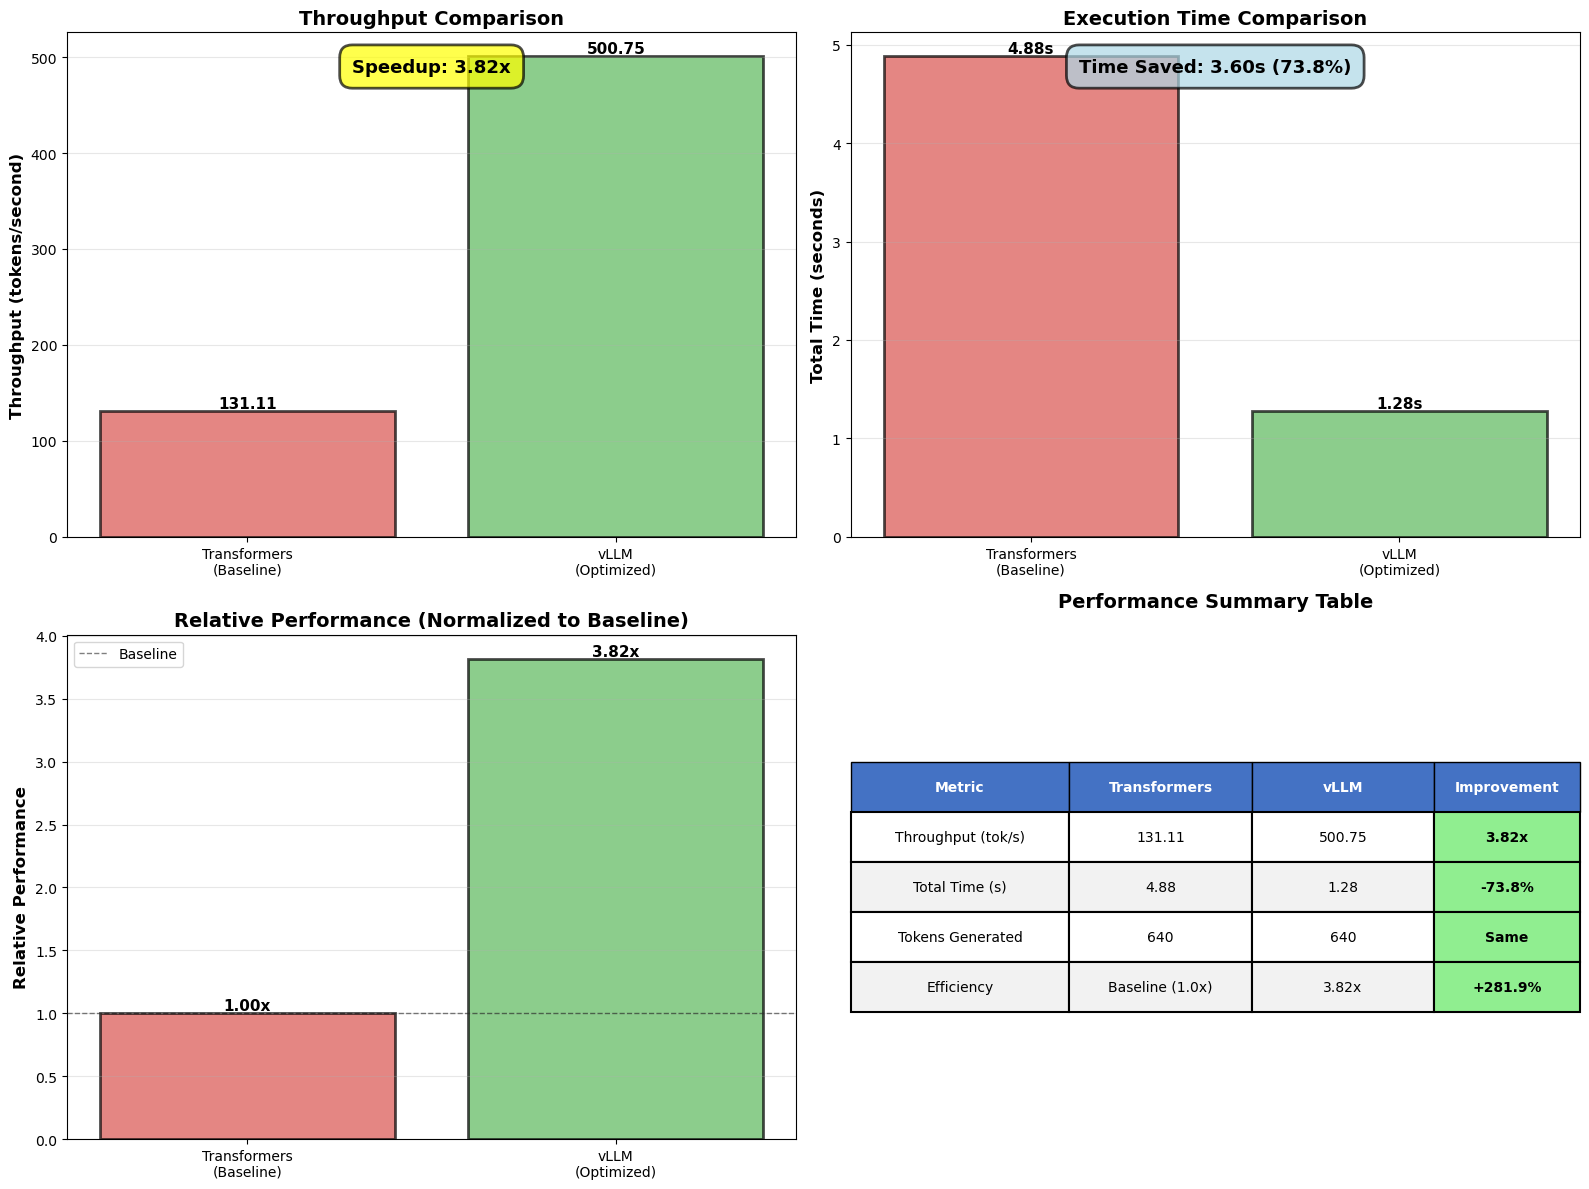


✅ Memory Optimization Experiment Complete!


In [4]:
# --- Create Comprehensive Visualizations ---
if optimized_perf > 0 and non_optimized_perf > 0:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Throughput Comparison
    engines = ['Transformers\n(Baseline)', 'vLLM\n(Optimized)']
    throughputs = [non_optimized_perf, optimized_perf]
    colors = ['#d9534f', '#5cb85c']
    
    bars1 = ax1.bar(engines, throughputs, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    ax1.set_ylabel('Throughput (tokens/second)', fontsize=12, fontweight='bold')
    ax1.set_title('Throughput Comparison', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Add speedup annotation
    speedup = optimized_perf / non_optimized_perf
    ax1.text(0.5, 0.95, f'Speedup: {speedup:.2f}x', 
             transform=ax1.transAxes, ha='center', va='top',
             fontsize=13, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.7', facecolor='yellow', alpha=0.7, edgecolor='black', linewidth=2))
    
    # Plot 2: Total Time Comparison
    times = [non_optimized_time, optimized_time]
    bars2 = ax2.bar(engines, times, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    ax2.set_ylabel('Total Time (seconds)', fontsize=12, fontweight='bold')
    ax2.set_title('Execution Time Comparison', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}s', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Add time saved annotation
    time_saved = non_optimized_time - optimized_time
    time_reduction_pct = (time_saved / non_optimized_time) * 100
    ax2.text(0.5, 0.95, f'Time Saved: {time_saved:.2f}s ({time_reduction_pct:.1f}%)', 
             transform=ax2.transAxes, ha='center', va='top',
             fontsize=13, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.7', facecolor='lightblue', alpha=0.7, edgecolor='black', linewidth=2))
    
    # Plot 3: Efficiency Comparison (Tokens per Second per Unit Time)
    efficiency = [throughputs[i] / times[i] if times[i] > 0 else 0 for i in range(len(engines))]
    bars3 = ax3.bar(engines, [1, speedup], color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    ax3.set_ylabel('Relative Performance', fontsize=12, fontweight='bold')
    ax3.set_title('Relative Performance (Normalized to Baseline)', fontsize=14, fontweight='bold')
    ax3.axhline(y=1, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Baseline')
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.legend()
    
    # Add value labels
    for i, bar in enumerate(bars3):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}x', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Plot 4: Summary Statistics Table
    ax4.axis('off')
    
    summary_data = [
        ['Metric', 'Transformers', 'vLLM', 'Improvement'],
        ['Throughput (tok/s)', f'{non_optimized_perf:.2f}', f'{optimized_perf:.2f}', f'{speedup:.2f}x'],
        ['Total Time (s)', f'{non_optimized_time:.2f}', f'{optimized_time:.2f}', f'-{time_reduction_pct:.1f}%'],
        ['Tokens Generated', f'{non_optimized_tokens}', f'{optimized_tokens}', 'Same'],
        ['Efficiency', 'Baseline (1.0x)', f'{speedup:.2f}x', f'+{((speedup-1)*100):.1f}%']
    ]
    
    table = ax4.table(cellText=summary_data, cellLoc='center', loc='center',
                     colWidths=[0.3, 0.25, 0.25, 0.2])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2.5)
    
    # Style the header row
    for i in range(4):
        cell = table[(0, i)]
        cell.set_facecolor('#4472C4')
        cell.set_text_props(weight='bold', color='white')
    
    # Alternate row colors
    for i in range(1, 5):
        for j in range(4):
            cell = table[(i, j)]
            if i % 2 == 0:
                cell.set_facecolor('#F2F2F2')
            cell.set_edgecolor('black')
            cell.set_linewidth(1.5)
    
    # Highlight improvement column
    for i in range(1, 5):
        cell = table[(i, 3)]
        cell.set_facecolor('#90EE90')
        cell.set_text_props(weight='bold')
    
    ax4.set_title('Performance Summary Table', fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.savefig("memory_optimization_comparison.png", dpi=150, bbox_inches='tight')
    print("\n📊 Comprehensive graph saved as 'memory_optimization_comparison.png'")
    plt.show()
    
    print("\n" + "="*60)
    print("✅ Memory Optimization Experiment Complete!")
    print("="*60)
else:
    print("\n⚠️ Could not run both tests to generate comparison graphs.")